In [2]:
from helpers import *

In [ ]:
data_path = r'D:\HUST\Semesters\2024.2\Vi xử lý\New_\DATA\DATA'
person_name = 'duc' # 'duc' 'duong' 'dung'

df_duc_data = read_log_to_csv(
    data_path=data_path,
    person=person_name,
    color=None,
    date=None,
)

df_duc_data

,pcg,ppg_red,ppg_ir
0,1079,27193.0,25138.0
1,30,27341.0,25177.0
2,-1215,27293.0,25153.0
3,-2347,27127.0,25074.0
4,2944,27130.0,25073.0
...,...,...,...
1981,-503,27593.0,25725.0
1982,-1068,27744.0,25784.0
1983,471,27818.0,25828.0
1984,-1804,27877.0,25846.0


In [5]:
#duc_pcg = df_duc_data_time[['pcg', 'timestamp']].copy()
duc_ppg_red = df_duc_data['ppg_red'].copy()
duc_ppg_ir = df_duc_data['ppg_ir'].copy()

fs_ppg = 500

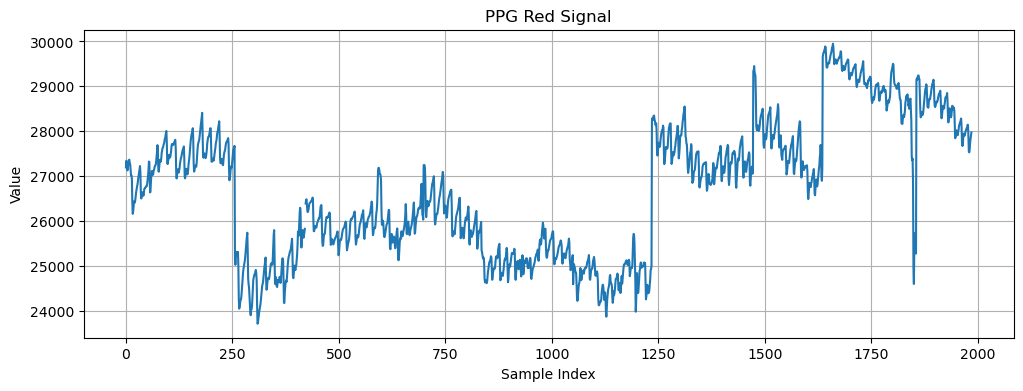

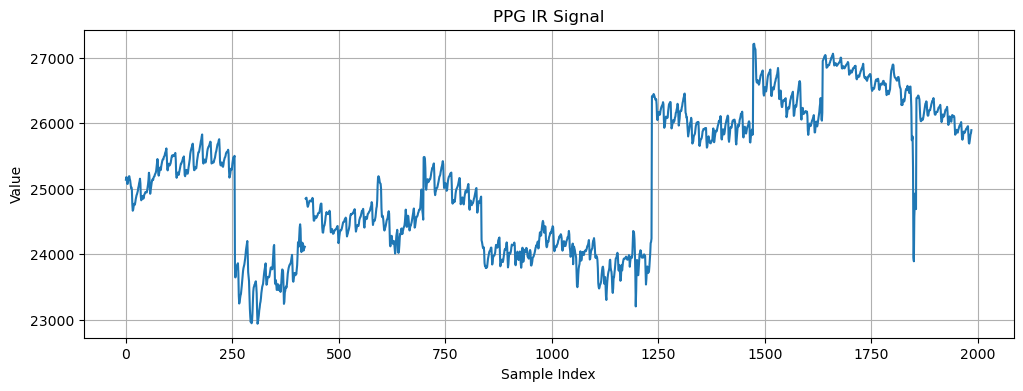

In [6]:
plot_signal(duc_ppg_red, title='PPG Red Signal')
plot_signal(duc_ppg_ir, title='PPG IR Signal')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def median_filter(signal, window_size):
    return pd.Series(signal).rolling(window=window_size, center=True, min_periods=1).median().to_numpy()

def is_peak(signal, i):
    if i <= 0 or i >= len(signal) - 1:
        return False
    return signal[i] > signal[i - 1] and signal[i] > signal[i + 1]

def calculate_bpm_window(signal, fs_ppg):
    ppg_filtered = median_filter(signal, int(0.1 * fs_ppg))
    RR = []
    last_peak = None
    for i in range(1, len(ppg_filtered) - 1):
        if is_peak(ppg_filtered, i):
            if last_peak is not None:
                diff = i - last_peak
                if diff > 0.34 * fs_ppg:
                    RR.append(diff)
            last_peak = i
    if len(RR) == 0:
        return 0
    return 60 * fs_ppg / np.mean(RR)

def calculate_bpm_series(PPG_red, fs_ppg=250, window_sec=10, step_sec=1):
    window_size = int(window_sec * fs_ppg)
    step_size = int(step_sec * fs_ppg)
    bpm_values = []
    time_values = []

    for start in range(0, len(PPG_red) - window_size, step_size):
        window = PPG_red[start:start + window_size]
        bpm = calculate_bpm_window(window, fs_ppg)
        bpm_values.append(bpm)
        time_values.append(start / fs_ppg)

    return time_values, bpm_values


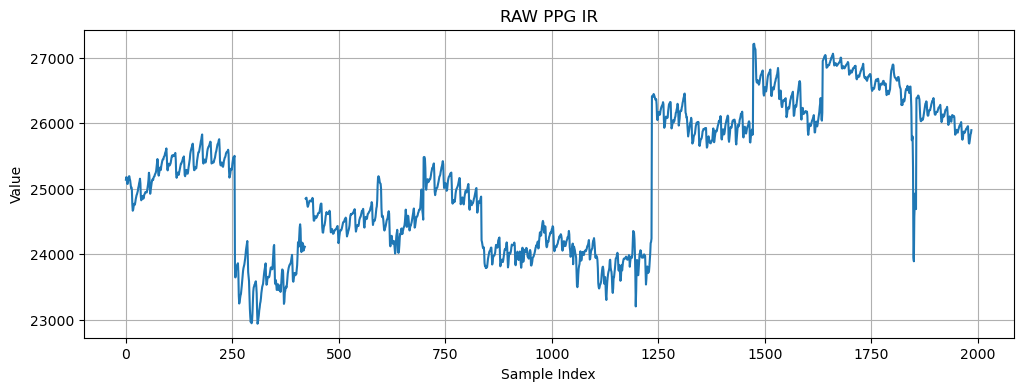

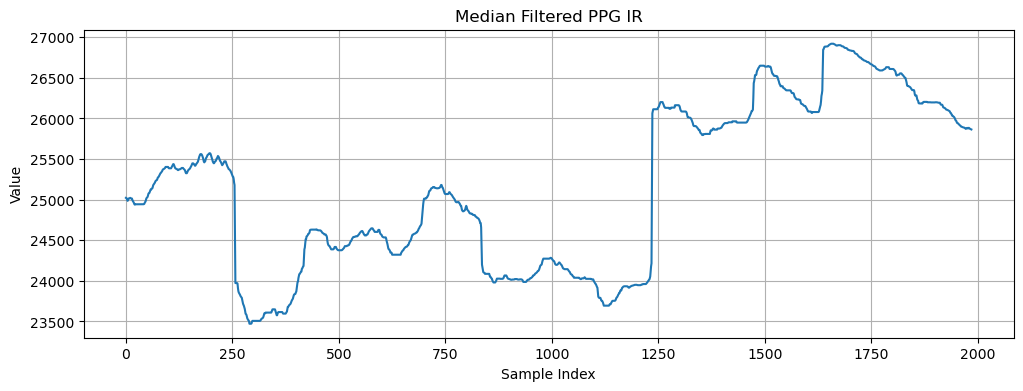

In [9]:
plot_signal(duc_ppg_ir, title='RAW PPG IR')
plot_signal(median_filter(duc_ppg_ir, int(0.1 * fs_ppg)), title='Median Filtered PPG IR')

In [10]:
def sliding_max(signal, window_size):
    return pd.Series(signal).rolling(window=window_size, center=True, min_periods=1).max().to_numpy()

def sliding_min(signal, window_size):
    return pd.Series(signal).rolling(window=window_size, center=True, min_periods=1).min().to_numpy()

def calculate_spo2(ppg_red, ppg_ir, fs_ppg=250):
    window_size = int(0.1 * fs_ppg)

    # Bước 1: Lọc trung vị
    red_filtered = median_filter(ppg_red, window_size)
    ir_filtered = median_filter(ppg_ir, window_size)

    # Bước 2: Max & Min theo cửa sổ trượt
    upper_red = sliding_max(red_filtered, window_size)
    lower_red = sliding_min(red_filtered, window_size)
    upper_ir = sliding_max(ir_filtered, window_size)
    lower_ir = sliding_min(ir_filtered, window_size)

    # Bước 3: Tìm đỉnh tín hiệu đỏ
    peak_indices, _ = find_peaks(red_filtered, distance=int(0.34 * fs_ppg))

    AC_red, DC_red, AC_ir, DC_ir = [], [], [], []

    # Bước 5: Tính AC và DC tại mỗi đỉnh
    for i in peak_indices:
        if i >= len(ppg_red): continue  # tránh lỗi chỉ số
        ac_r = upper_red[i] - lower_red[i]
        dc_r = lower_red[i]
        ac_ir = upper_ir[i] - lower_ir[i]
        dc_ir = lower_ir[i]

        if dc_r == 0 or dc_ir == 0:
            continue  # tránh chia cho 0

        AC_red.append(ac_r)
        DC_red.append(dc_r)
        AC_ir.append(ac_ir)
        DC_ir.append(dc_ir)

    # Tính tỉ lệ r = (AC_red/DC_red) / (AC_ir/DC_ir)
    r_values = [(ac_r / dc_r) / (ac_ir / dc_ir) for ac_r, dc_r, ac_ir, dc_ir in zip(AC_red, DC_red, AC_ir, DC_ir)]

    if len(r_values) == 0:
        return 0  # không có dữ liệu đủ

    r_mean = np.mean(r_values)

    # Bước 6: Tính SpO2 theo công thức thực nghiệm
    spo2 = 110 - 25 * r_mean
    spo2 = np.clip(spo2, 0, 100)  # giữ trong khoảng 0–100%

    return spo2


In [11]:
max_val = 0

for temp in range(100, 1000, 25):
    print(f"Estimated SpO₂: {calculate_spo2(duc_ppg_red, duc_ppg_ir, temp):.2f}%")
    max_val = max(max_val, calculate_spo2(duc_ppg_red, duc_ppg_ir, temp))

print(f"Max Estimated SpO₂: {max_val:.2f}%")

Estimated SpO₂: 60.34%
Estimated SpO₂: 60.40%
Estimated SpO₂: 59.49%
Estimated SpO₂: 61.44%
Estimated SpO₂: 63.16%
Estimated SpO₂: 64.97%
Estimated SpO₂: 62.77%
Estimated SpO₂: 61.07%
Estimated SpO₂: 62.48%
Estimated SpO₂: 62.47%
Estimated SpO₂: 59.99%
Estimated SpO₂: 58.25%
Estimated SpO₂: 64.11%
Estimated SpO₂: 62.51%
Estimated SpO₂: 62.78%
Estimated SpO₂: 54.93%
Estimated SpO₂: 63.72%
Estimated SpO₂: 55.08%
Estimated SpO₂: 60.06%
Estimated SpO₂: 65.66%
Estimated SpO₂: 65.34%
Estimated SpO₂: 65.69%
Estimated SpO₂: 63.99%
Estimated SpO₂: 65.40%
Estimated SpO₂: 66.99%
Estimated SpO₂: 65.78%
Estimated SpO₂: 66.07%
Estimated SpO₂: 61.34%
Estimated SpO₂: 68.52%
Estimated SpO₂: 67.65%
Estimated SpO₂: 66.11%
Estimated SpO₂: 66.62%
Estimated SpO₂: 64.77%
Estimated SpO₂: 63.58%
Estimated SpO₂: 63.28%
Estimated SpO₂: 62.85%
Max Estimated SpO₂: 68.52%


In [ ]:
time_vals, bpm_vals = calculate_bpm_series(duc_ppg_ir, fs_ppg=250, window_sec=8,step_sec=1)

if len(bpm_vals) > 1:
    plt.plot(time_vals, bpm_vals, marker='o')
    plt.xlabel("Time (s)")
    plt.ylabel("Heart Rate (BPM)")
    plt.title("Heart Rate Over Time")
    plt.grid(True)
    plt.show()
else:
    print(f"BPM values {bpm_vals}")

BPM values []
